# IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path

# Image processing
import imageio
import cv2
import skimage.transform


# Charts
import matplotlib.pyplot as plt
import seaborn as sns

# ML, statistics
import scipy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

# SETTINGS

## Global

In [2]:
# Settings
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn')

# toy=True - development mode, small samples, limited training, fast run
# toy=False - full data, slow learning and run
toy=False

#set size of validation set and test set in percentage
validation_size = 10
test_size = 10

# Generators Paramenters
batch_size = 32
img_size = (224,224)

## Dataset Parameters

In [3]:
# Dataset Root Path
dataset_path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

# Folder Paths
covid_path = dataset_path + "/COVID/images"
lungOpacity_path = dataset_path + "/Lung_Opacity/images"
normal_path = dataset_path + "/Normal/images"
viralPneumonia_path = dataset_path + "/Viral Pneumonia/images"

# LABELS LOCAL Array
#labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
labels = ['COVID', 'Normal', 'Viral Pneumonia']

# DATA PREPARATION

In [4]:
# Generate Filename list
def filename_list():

    if toy :
        random.seed(100)
        filenames = random.sample(os.listdir(covid_path), 200) + random.sample(os.listdir(lungOpacity_path), 200) + random.sample(os.listdir(normal_path), 200) + random.sample(os.listdir(viralPneumonia_path), 200)
    else :
       #filenames = os.listdir(covid_path) + os.listdir(lungOpacity_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)
        filenames = os.listdir(covid_path) + os.listdir(normal_path) + os.listdir(viralPneumonia_path)

    return filenames

In [5]:
def dataframe_generation(files):
    
    categories = []
    for filename in files:
        category = filename.split('-')[0]
        if category == labels[0]:
            categories.append(str(0))
        elif category == labels[1]:
            categories.append(str(1))
        elif category == labels[2]:
            categories.append(str(2))
        #elif category == labels[3]:
         #   categories.append(str(3))

    for i in range(len(files)):
        if labels[0] in files[i]:
            files[i] = os.path.join(covid_path, files[i])
        #elif labels[1] in files[i]:
            #files[i] = os.path.join(lungOpacity_path, files[i])
        elif labels[1] in files[i]:
            files[i] = os.path.join(normal_path, files[i])
        elif labels[2] in files[i]:
            files[i] = os.path.join(viralPneumonia_path, files[i])
    
    df = pd.DataFrame({
        'filename': files,
        'category': categories
    })

    return df

## Generate Dataset

In [6]:
filenames = filename_list()
dataset_df = dataframe_generation(filenames)

dataset_df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,0
1,../input/covid19-radiography-database/COVID-19...,0
2,../input/covid19-radiography-database/COVID-19...,0
3,../input/covid19-radiography-database/COVID-19...,0
4,../input/covid19-radiography-database/COVID-19...,0


In [7]:
def read_img(id):
    """
    Read image by it's id
    """
    file=id
    im=cv2.imread(file)
    return im

def draw_sample_images(dataframe, ncols, labels):

        ncols=ncols
        n_rows = len(labels)

        f, ax = plt.subplots(nrows=n_rows,ncols=ncols, 
                             figsize=(4*ncols,5*2))
        i=-1
        captions=labels
        
        for label in range(n_rows):
            i=i+1
            samples = dataframe[dataframe["category"].astype(int) == label].filename.sample(ncols).values
            for j in range(0,ncols):
                file_id=samples[j]
                im=read_img(file_id)
                ax[i, j].imshow(im)
                ax[i, j].set_title(captions[i], fontsize=16)  
        plt.tight_layout()
        plt.show()

In [8]:
def plot_data_distribution(dataframe):
    y = np.bincount(dataframe.category)
    x = labels
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(x, y,width=0.7)
    ax.set_xticks(x)
    ax.set_aspect('auto')
    plt.show()

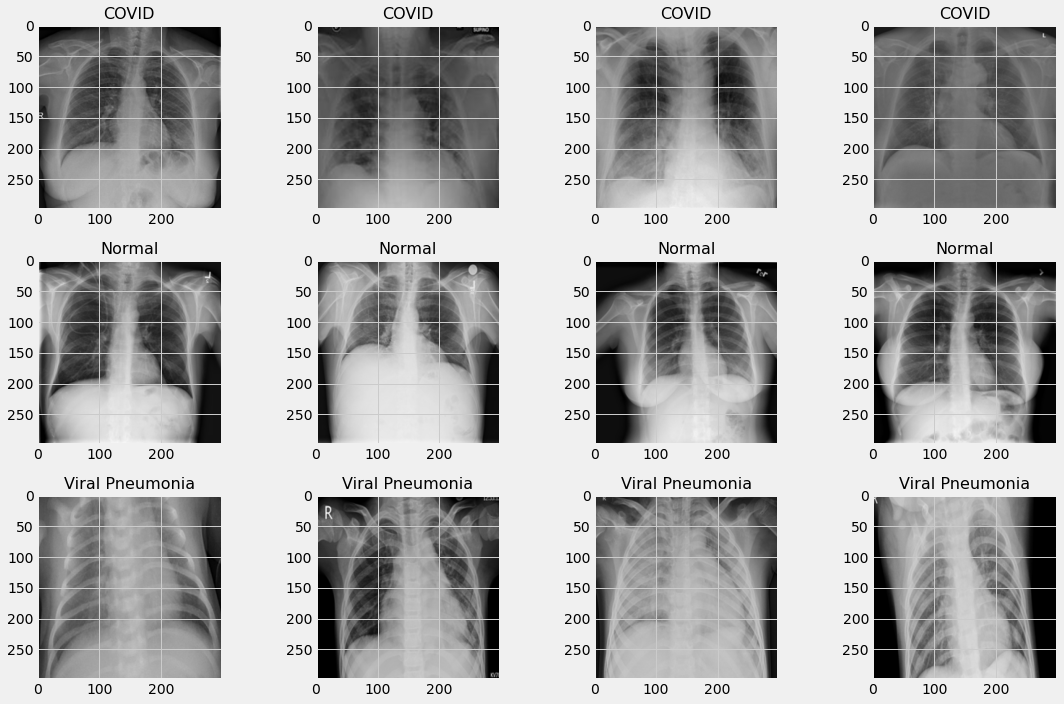

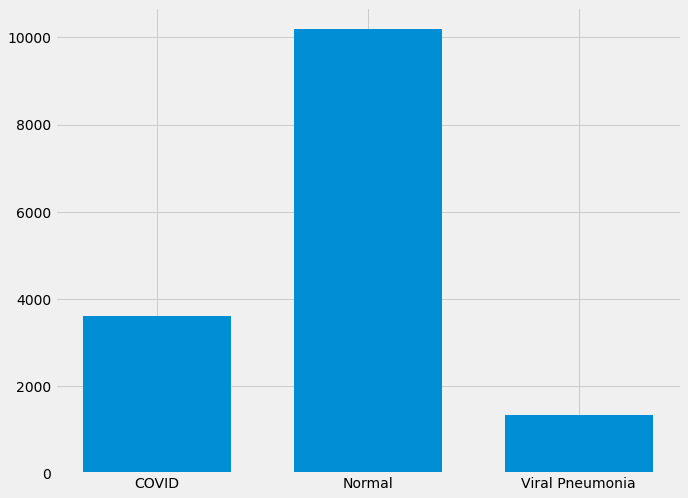

In [9]:
draw_sample_images(dataset_df, 4, labels)
plot_data_distribution(dataset_df)

## Split in Train, Validation and Test

In [12]:
def sets_split(dataframe):
    x_1_split = (validation_size + test_size)/100
    x_2_split = round(test_size / (validation_size + test_size), 2)

    train_df, valTest_df = train_test_split(dataframe, test_size=x_1_split, random_state=24)
    val_df, test_df = train_test_split(valTest_df, test_size=x_2_split, random_state=24)

    return train_df, val_df, test_df

In [13]:
train, validation, test = sets_split(dataset_df)

## Generators

In [14]:
_datagen = ImageDataGenerator(
            rotation_range=15,
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1   
            )

_test_datagen=ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = _datagen.flow_from_dataframe(
            dataframe=train,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)
print('Train generator created')

Found 12122 validated image filenames belonging to 3 classes.
Train generator created


In [16]:
val_generator = _test_datagen.flow_from_dataframe(
            dataframe=validation,
            x_col="filename",
            y_col="category",
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            class_mode="categorical",
            color_mode="rgb",
            target_size=img_size)    
print('Validation generator created')

Found 1515 validated image filenames belonging to 3 classes.
Validation generator created


In [17]:
test_generator = _test_datagen.flow_from_dataframe(
            dataframe=test,
            x_col="filename",
            y_col=None,
            class_mode=None,
            batch_size=batch_size,
            seed=42,
            shuffle=False,
            color_mode="rgb",
            target_size=img_size)     
print('Test generator created')

Found 1516 validated image filenames.
Test generator created


# MODEL GENERATION

## Metrics Aux Functions

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model Creation

In [19]:
def create_model(size):
        model = Sequential()

        model.add(BatchNormalization(input_shape=(224,224,3)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(0.35))

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.35))
        model.add(Dense(3, activation='softmax'))
            
        model.compile(optimizer= Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
        
        return model

In [20]:
model = create_model(224)
model.summary()

2022-06-22 07:02:55.686305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 07:02:55.783515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 07:02:55.784350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 07:02:55.785958: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 32)        1

## Define Trainer

In [21]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt    
import matplotlib.patches as mpatches  
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


class AccLossPlotter(Callback):
    """Plot training Accuracy and Loss values on a Matplotlib graph. 
    The graph is updated by the 'on_epoch_end' event of the Keras Callback class
    # Arguments
        graphs: list with some or all of ('acc', 'loss')
        save_graph: Save graph as an image on Keras Callback 'on_train_end' event 
    """

    def __init__(self, graphs=['acc', 'loss'], save_graph=False):
        self.graphs = graphs
        self.num_subplots = len(graphs)
        self.save_graph = save_graph


    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []
        self.loss = []
        self.val_loss = []
        self.epoch_count = 0
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        self.epoch_count += 1
        self.val_acc.append(logs.get('val_accuracy'))
        self.acc.append(logs.get('accuracy'))
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        epochs = [x for x in range(self.epoch_count)]

        count_subplots = 0
        
        if 'acc' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Accuracy')
            #plt.axis([0,100,0,1])
            plt.plot(epochs, self.val_acc, color='r')
            plt.plot(epochs, self.acc, color='b')
            plt.ylabel('accuracy')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)

        if 'loss' in self.graphs:
            count_subplots += 1
            plt.subplot(self.num_subplots, 1, count_subplots)
            plt.title('Loss')
            #plt.axis([0,100,0,5])
            plt.plot(epochs, self.val_loss, color='r')
            plt.plot(epochs, self.loss, color='b')
            plt.ylabel('loss')

            red_patch = mpatches.Patch(color='red', label='Test')
            blue_patch = mpatches.Patch(color='blue', label='Train')

            plt.legend(handles=[red_patch, blue_patch], loc=4)
        
        plt.draw()
        plt.pause(0.001)

    def on_train_end(self, logs={}):
        if self.save_graph:
            plt.savefig('training_acc_loss.png')

class ConfusionMatrixPlotter(Callback):
    """Plot the confusion matrix on a graph and update after each epoch
    # Arguments
        X_val: The input values 
        Y_val: The expected output values
        classes: The categories as a list of string names
        normalize: True - normalize to [0,1], False - keep as is
        cmap: Specify matplotlib colour map
        title: Graph Title
    """
    def __init__(self, X_val, Y_val, classes, normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix'):
        self.X_val = X_val
        self.Y_val = Y_val
        self.title = title
        self.classes = classes
        self.normalize = normalize
        self.cmap = cmap
        plt.ion()
        #plt.show()
        #plt.figure()

        #plt.title(self.title)
        
        

    def on_train_begin(self, logs={}):
        pass

    
    def on_epoch_end(self, epoch, logs={}):    
        plt.clf()
        pred = self.model.predict(self.X_val)
        max_pred = np.argmax(pred, axis=1)
        max_y = self.Y_val
        max_y=max_y[:len(max_pred)] 
        cnf_mat = confusion_matrix(max_y, max_pred)
   
        if self.normalize:
            cnf_mat = cnf_mat.astype('float') / cnf_mat.sum(axis=1)[:, np.newaxis]

        thresh = cnf_mat.max() / 2.
        for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
            plt.text(j, i, cnf_mat[i, j],                                          
                         horizontalalignment="center",
                         color="white" if cnf_mat[i, j] > thresh else "black")

        plt.imshow(cnf_mat, interpolation='nearest', cmap=self.cmap)

        # Labels
        tick_marks = np.arange(len(self.classes))
        plt.xticks(tick_marks, self.classes, rotation=45)
        plt.yticks(tick_marks, self.classes)

        plt.colorbar()
                                                                                                         
        plt.tight_layout()                                                    
        plt.ylabel('True label')                                              
        plt.xlabel('Predicted label')                                         
        #plt.draw()
        plt.show()
        plt.pause(0.001)

In [22]:
plotter = ConfusionMatrixPlotter(X_val=val_generator, classes=labels, Y_val=validation.category.values.astype(int))
loss_acc = AccLossPlotter()

In [23]:
def train(model, train_data, val_data, toy):
        """
        Train the model
        """
        if toy:
            epochs=3

        else:
            epochs=100
            
        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(monitor='val_loss', mode='min', patience=5 , restore_best_weights=True)

        # Save the best model during the traning
        checkpointer = ModelCheckpoint('best_model1.h5'
                                        ,monitor='val_loss'
                                        ,mode='min'
                                        ,verbose=1
                                        ,save_best_only=True)
        # Train
        training = model.fit(train_data, 
                            validation_data = val_data, 
                            epochs = epochs, 
                            verbose = 1,
                            batch_size = batch_size,
                            callbacks=[earlystopper, checkpointer,plotter, loss_acc])
        
        print("Trained")
                            
        return training

2022-06-22 07:02:59.325636: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-22 07:03:01.667184: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


379/379 [==============================] - 259s 663ms/step - loss: 0.6427 - accuracy: 0.7060 - f1_m: 0.6967 - precision_m: 0.7245 - recall_m: 0.6722 - val_loss: 0.5605 - val_accuracy: 0.7736 - val_f1_m: 0.7561 - val_precision_m: 0.8060 - val_recall_m: 0.7137

Epoch 00001: val_loss improved from inf to 0.56050, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


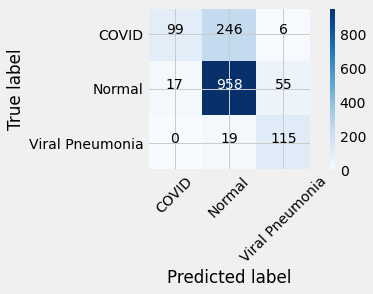

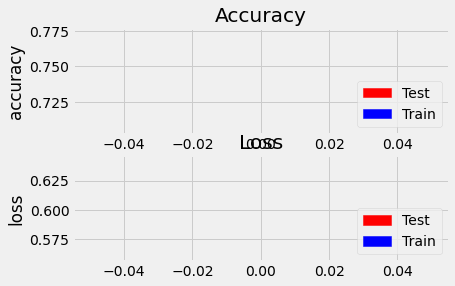

Epoch 2/100
379/379 [==============================] - 165s 434ms/step - loss: 0.5637 - accuracy: 0.7406 - f1_m: 0.7363 - precision_m: 0.7552 - recall_m: 0.7189 - val_loss: 0.4956 - val_accuracy: 0.8356 - val_f1_m: 0.8252 - val_precision_m: 0.8654 - val_recall_m: 0.7898

Epoch 00002: val_loss improved from 0.56050 to 0.49564, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


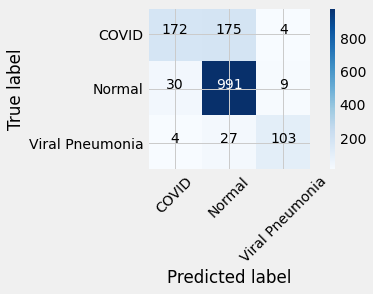

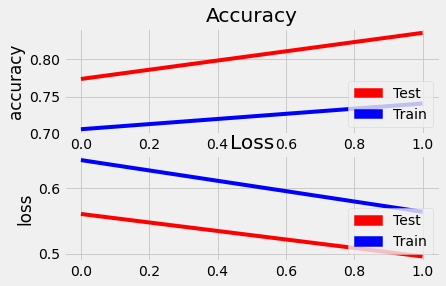

Epoch 3/100
379/379 [==============================] - 162s 428ms/step - loss: 0.5217 - accuracy: 0.7658 - f1_m: 0.7621 - precision_m: 0.7777 - recall_m: 0.7477 - val_loss: 0.4194 - val_accuracy: 0.8284 - val_f1_m: 0.8253 - val_precision_m: 0.8381 - val_recall_m: 0.8132

Epoch 00003: val_loss improved from 0.49564 to 0.41940, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


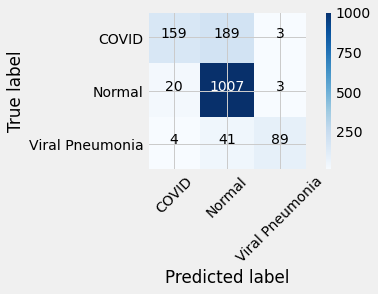

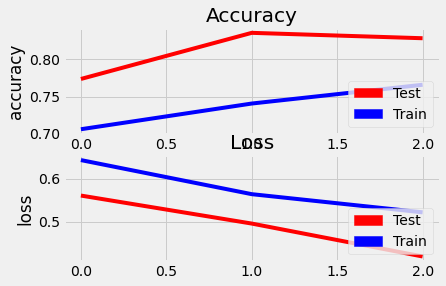

Epoch 4/100
379/379 [==============================] - 162s 428ms/step - loss: 0.4873 - accuracy: 0.7830 - f1_m: 0.7793 - precision_m: 0.7927 - recall_m: 0.7668 - val_loss: 0.3814 - val_accuracy: 0.8561 - val_f1_m: 0.8513 - val_precision_m: 0.8635 - val_recall_m: 0.8399

Epoch 00004: val_loss improved from 0.41940 to 0.38136, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


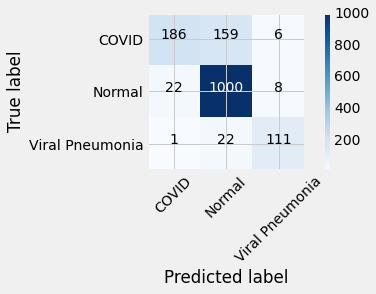

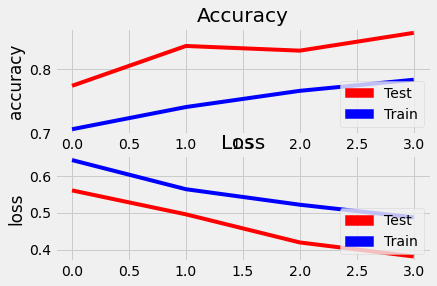

Epoch 5/100
379/379 [==============================] - 163s 430ms/step - loss: 0.4698 - accuracy: 0.7891 - f1_m: 0.7864 - precision_m: 0.7999 - recall_m: 0.7738 - val_loss: 0.3650 - val_accuracy: 0.8416 - val_f1_m: 0.8407 - val_precision_m: 0.8471 - val_recall_m: 0.8347

Epoch 00005: val_loss improved from 0.38136 to 0.36502, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


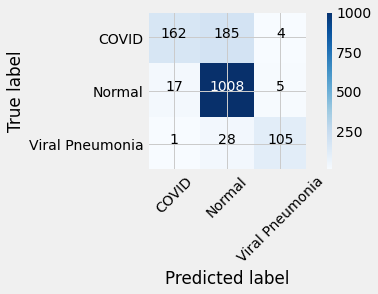

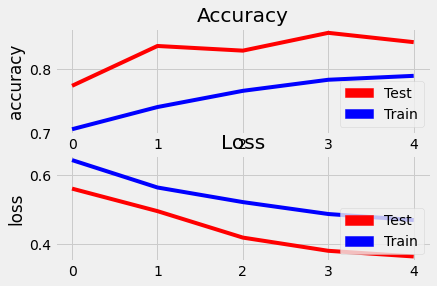

Epoch 6/100
379/379 [==============================] - 164s 434ms/step - loss: 0.4551 - accuracy: 0.8010 - f1_m: 0.7996 - precision_m: 0.8108 - recall_m: 0.7890 - val_loss: 0.3512 - val_accuracy: 0.8541 - val_f1_m: 0.8543 - val_precision_m: 0.8605 - val_recall_m: 0.8484

Epoch 00006: val_loss improved from 0.36502 to 0.35123, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


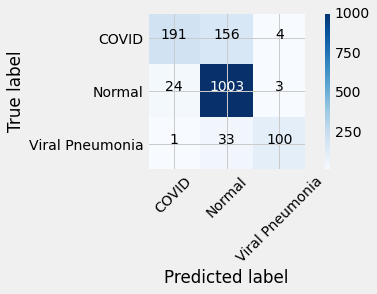

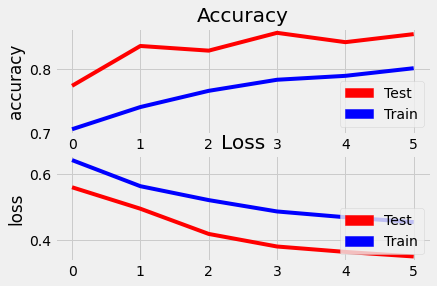

Epoch 7/100
379/379 [==============================] - 164s 434ms/step - loss: 0.4432 - accuracy: 0.8117 - f1_m: 0.8093 - precision_m: 0.8206 - recall_m: 0.7988 - val_loss: 0.3401 - val_accuracy: 0.8693 - val_f1_m: 0.8659 - val_precision_m: 0.8739 - val_recall_m: 0.8582

Epoch 00007: val_loss improved from 0.35123 to 0.34008, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


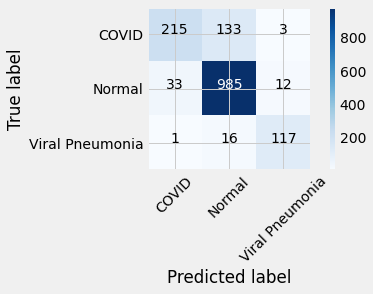

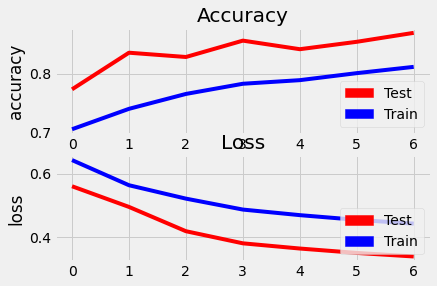

Epoch 8/100
379/379 [==============================] - 163s 432ms/step - loss: 0.4302 - accuracy: 0.8145 - f1_m: 0.8128 - precision_m: 0.8221 - recall_m: 0.8041 - val_loss: 0.3238 - val_accuracy: 0.8739 - val_f1_m: 0.8729 - val_precision_m: 0.8802 - val_recall_m: 0.8659

Epoch 00008: val_loss improved from 0.34008 to 0.32379, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


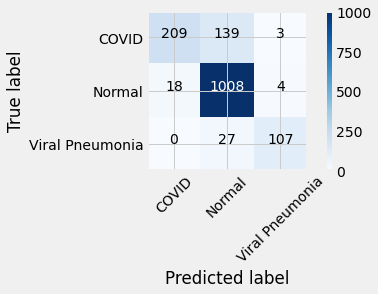

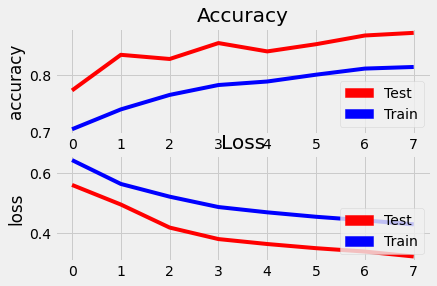

Epoch 9/100
379/379 [==============================] - 167s 440ms/step - loss: 0.4133 - accuracy: 0.8235 - f1_m: 0.8225 - precision_m: 0.8304 - recall_m: 0.8149 - val_loss: 0.3050 - val_accuracy: 0.8818 - val_f1_m: 0.8811 - val_precision_m: 0.8852 - val_recall_m: 0.8771

Epoch 00009: val_loss improved from 0.32379 to 0.30503, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


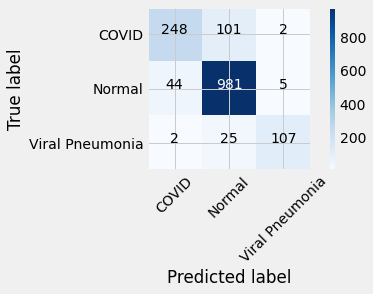

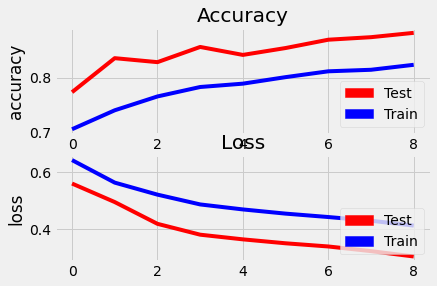

Epoch 10/100
379/379 [==============================] - 164s 431ms/step - loss: 0.4047 - accuracy: 0.8281 - f1_m: 0.8258 - precision_m: 0.8344 - recall_m: 0.8177 - val_loss: 0.2946 - val_accuracy: 0.8858 - val_f1_m: 0.8846 - val_precision_m: 0.8879 - val_recall_m: 0.8816

Epoch 00010: val_loss improved from 0.30503 to 0.29456, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


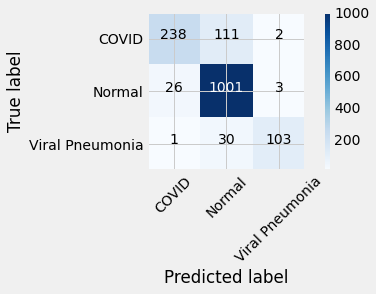

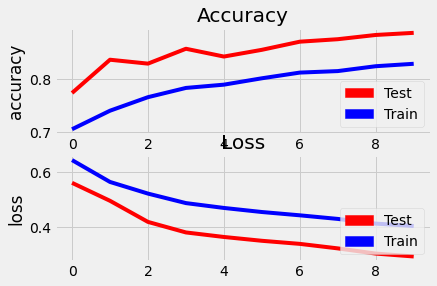

Epoch 11/100
379/379 [==============================] - 162s 428ms/step - loss: 0.3973 - accuracy: 0.8342 - f1_m: 0.8331 - precision_m: 0.8409 - recall_m: 0.8257 - val_loss: 0.3036 - val_accuracy: 0.8752 - val_f1_m: 0.8735 - val_precision_m: 0.8793 - val_recall_m: 0.8679

Epoch 00011: val_loss did not improve from 0.29456


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


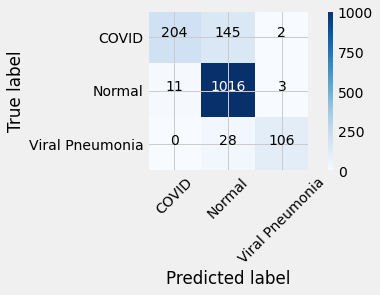

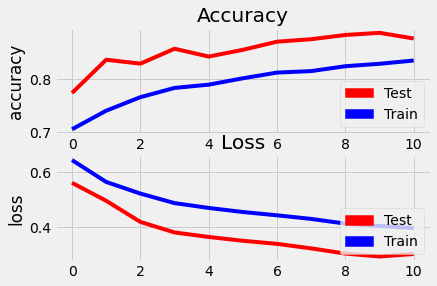

Epoch 12/100
379/379 [==============================] - 163s 429ms/step - loss: 0.3848 - accuracy: 0.8368 - f1_m: 0.8355 - precision_m: 0.8426 - recall_m: 0.8287 - val_loss: 0.2748 - val_accuracy: 0.8917 - val_f1_m: 0.8920 - val_precision_m: 0.8968 - val_recall_m: 0.8874

Epoch 00012: val_loss improved from 0.29456 to 0.27477, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


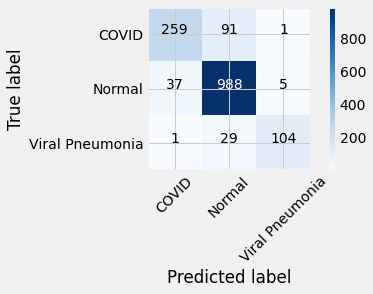

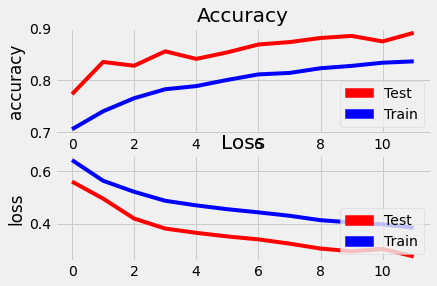

Epoch 13/100
379/379 [==============================] - 162s 427ms/step - loss: 0.3751 - accuracy: 0.8448 - f1_m: 0.8435 - precision_m: 0.8507 - recall_m: 0.8365 - val_loss: 0.2595 - val_accuracy: 0.8990 - val_f1_m: 0.8991 - val_precision_m: 0.9039 - val_recall_m: 0.8946

Epoch 00013: val_loss improved from 0.27477 to 0.25953, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


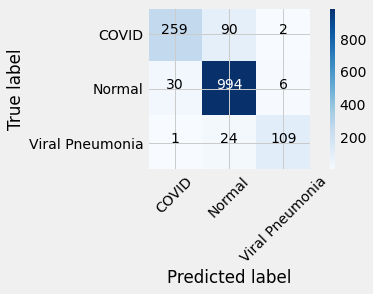

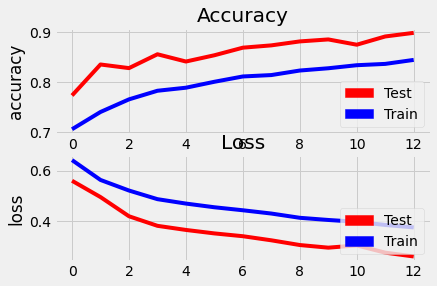

Epoch 14/100
379/379 [==============================] - 162s 428ms/step - loss: 0.3704 - accuracy: 0.8443 - f1_m: 0.8443 - precision_m: 0.8517 - recall_m: 0.8373 - val_loss: 0.2728 - val_accuracy: 0.8990 - val_f1_m: 0.8950 - val_precision_m: 0.8974 - val_recall_m: 0.8927

Epoch 00014: val_loss did not improve from 0.25953


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


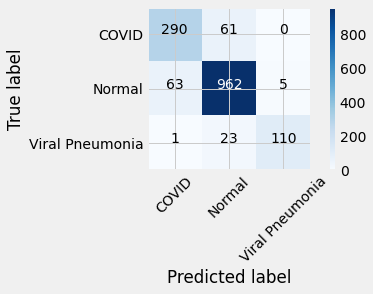

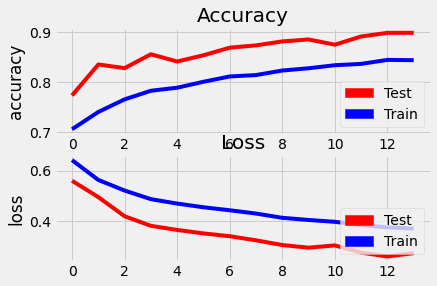

Epoch 15/100
379/379 [==============================] - 162s 427ms/step - loss: 0.3587 - accuracy: 0.8501 - f1_m: 0.8485 - precision_m: 0.8558 - recall_m: 0.8416 - val_loss: 0.2614 - val_accuracy: 0.9023 - val_f1_m: 0.9019 - val_precision_m: 0.9055 - val_recall_m: 0.8985

Epoch 00015: val_loss did not improve from 0.25953


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


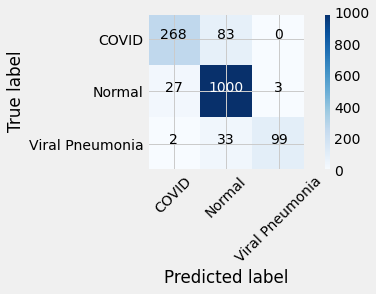

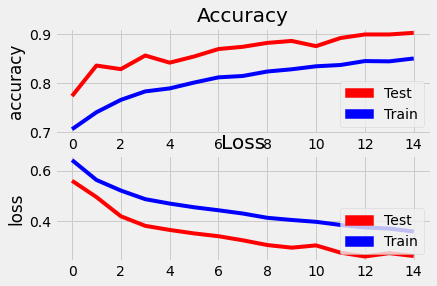

Epoch 16/100
379/379 [==============================] - 163s 429ms/step - loss: 0.3506 - accuracy: 0.8508 - f1_m: 0.8493 - precision_m: 0.8550 - recall_m: 0.8439 - val_loss: 0.2426 - val_accuracy: 0.9135 - val_f1_m: 0.9119 - val_precision_m: 0.9143 - val_recall_m: 0.9096

Epoch 00016: val_loss improved from 0.25953 to 0.24258, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


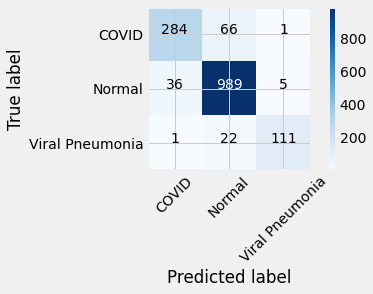

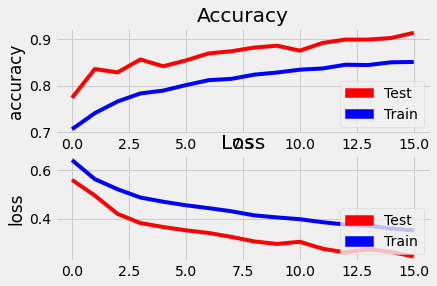

Epoch 17/100
379/379 [==============================] - 164s 432ms/step - loss: 0.3360 - accuracy: 0.8598 - f1_m: 0.8593 - precision_m: 0.8647 - recall_m: 0.8542 - val_loss: 0.2366 - val_accuracy: 0.9122 - val_f1_m: 0.9093 - val_precision_m: 0.9117 - val_recall_m: 0.9070

Epoch 00017: val_loss improved from 0.24258 to 0.23659, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


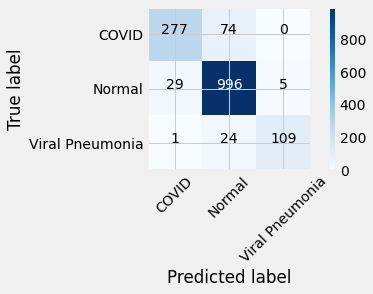

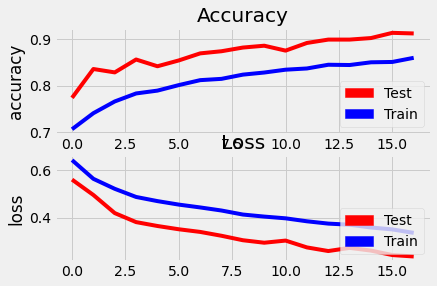

Epoch 18/100
379/379 [==============================] - 164s 432ms/step - loss: 0.3260 - accuracy: 0.8629 - f1_m: 0.8620 - precision_m: 0.8672 - recall_m: 0.8570 - val_loss: 0.2680 - val_accuracy: 0.8983 - val_f1_m: 0.8978 - val_precision_m: 0.9005 - val_recall_m: 0.8952

Epoch 00018: val_loss did not improve from 0.23659


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


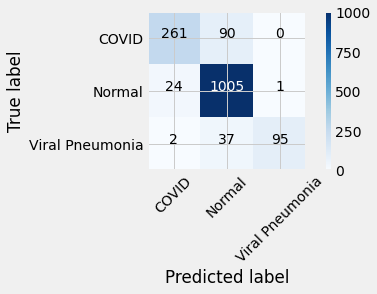

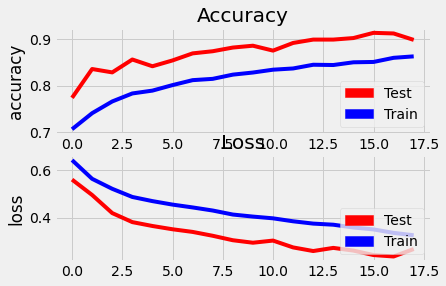

Epoch 19/100
379/379 [==============================] - 164s 432ms/step - loss: 0.3185 - accuracy: 0.8664 - f1_m: 0.8663 - precision_m: 0.8712 - recall_m: 0.8617 - val_loss: 0.2260 - val_accuracy: 0.9102 - val_f1_m: 0.9111 - val_precision_m: 0.9119 - val_recall_m: 0.9102

Epoch 00019: val_loss improved from 0.23659 to 0.22602, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


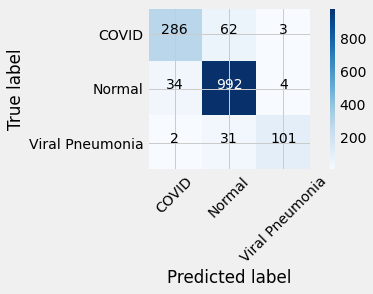

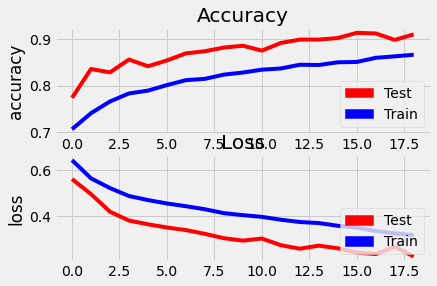

Epoch 20/100
379/379 [==============================] - 163s 430ms/step - loss: 0.3105 - accuracy: 0.8754 - f1_m: 0.8745 - precision_m: 0.8791 - recall_m: 0.8701 - val_loss: 0.2271 - val_accuracy: 0.9135 - val_f1_m: 0.9127 - val_precision_m: 0.9138 - val_recall_m: 0.9115

Epoch 00020: val_loss did not improve from 0.22602


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


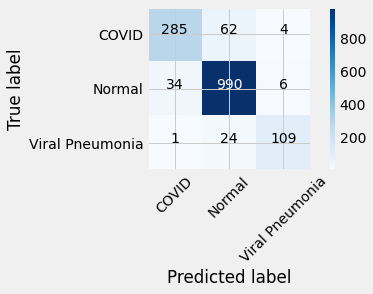

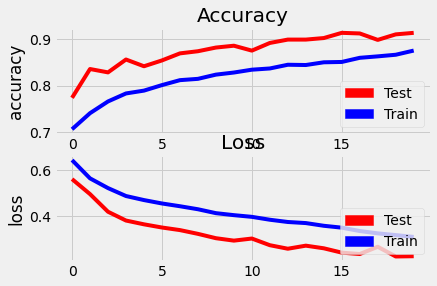

Epoch 21/100
379/379 [==============================] - 163s 431ms/step - loss: 0.3083 - accuracy: 0.8745 - f1_m: 0.8733 - precision_m: 0.8774 - recall_m: 0.8693 - val_loss: 0.2178 - val_accuracy: 0.9142 - val_f1_m: 0.9144 - val_precision_m: 0.9174 - val_recall_m: 0.9115

Epoch 00021: val_loss improved from 0.22602 to 0.21777, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


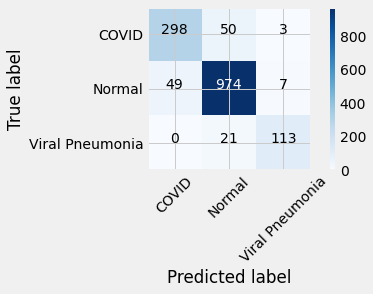

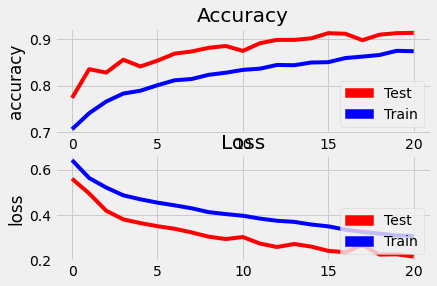

Epoch 22/100
379/379 [==============================] - 163s 431ms/step - loss: 0.3045 - accuracy: 0.8746 - f1_m: 0.8739 - precision_m: 0.8779 - recall_m: 0.8699 - val_loss: 0.2234 - val_accuracy: 0.9089 - val_f1_m: 0.9081 - val_precision_m: 0.9093 - val_recall_m: 0.9070

Epoch 00022: val_loss did not improve from 0.21777


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


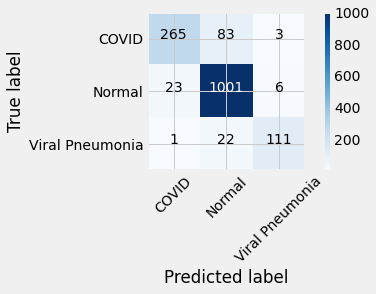

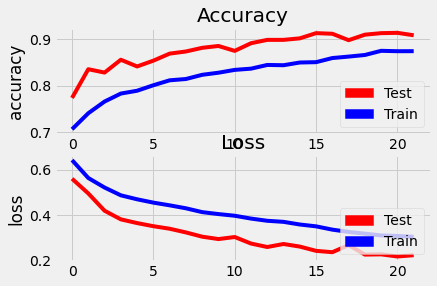

Epoch 23/100
379/379 [==============================] - 163s 431ms/step - loss: 0.2871 - accuracy: 0.8798 - f1_m: 0.8794 - precision_m: 0.8833 - recall_m: 0.8757 - val_loss: 0.2377 - val_accuracy: 0.9135 - val_f1_m: 0.9125 - val_precision_m: 0.9129 - val_recall_m: 0.9122

Epoch 00023: val_loss did not improve from 0.21777


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


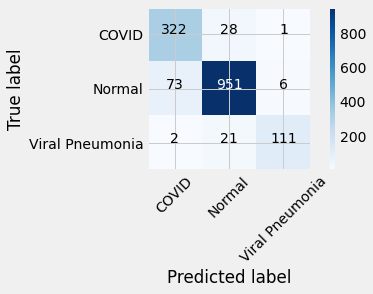

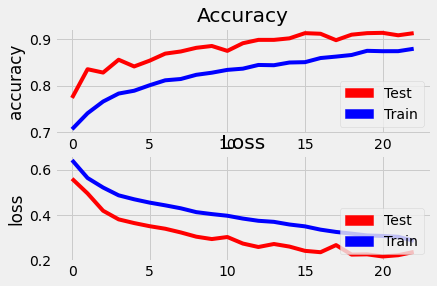

Epoch 24/100
379/379 [==============================] - 164s 432ms/step - loss: 0.2874 - accuracy: 0.8832 - f1_m: 0.8830 - precision_m: 0.8866 - recall_m: 0.8796 - val_loss: 0.2468 - val_accuracy: 0.9043 - val_f1_m: 0.9033 - val_precision_m: 0.9049 - val_recall_m: 0.9018

Epoch 00024: val_loss did not improve from 0.21777


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


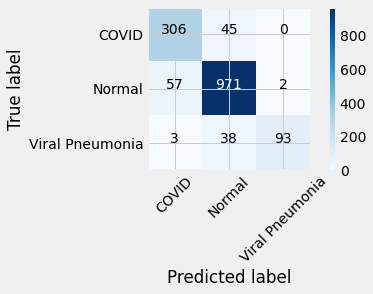

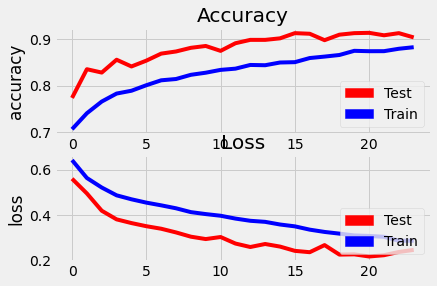

Epoch 25/100
379/379 [==============================] - 163s 430ms/step - loss: 0.2779 - accuracy: 0.8891 - f1_m: 0.8890 - precision_m: 0.8920 - recall_m: 0.8860 - val_loss: 0.2357 - val_accuracy: 0.9162 - val_f1_m: 0.9157 - val_precision_m: 0.9167 - val_recall_m: 0.9148

Epoch 00025: val_loss did not improve from 0.21777


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


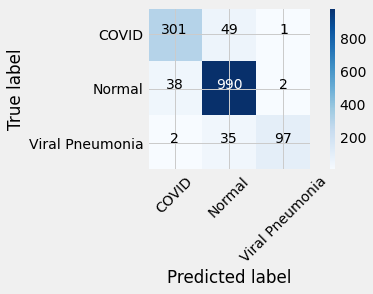

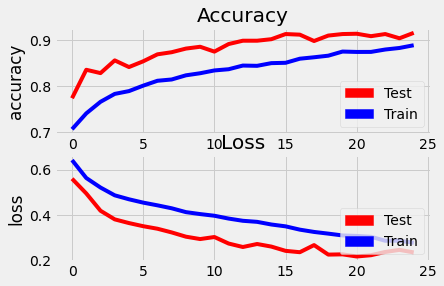

Epoch 26/100
379/379 [==============================] - 163s 430ms/step - loss: 0.2862 - accuracy: 0.8852 - f1_m: 0.8848 - precision_m: 0.8887 - recall_m: 0.8811 - val_loss: 0.2124 - val_accuracy: 0.9228 - val_f1_m: 0.9219 - val_precision_m: 0.9231 - val_recall_m: 0.9207

Epoch 00026: val_loss improved from 0.21777 to 0.21237, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


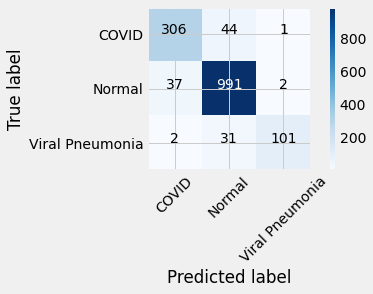

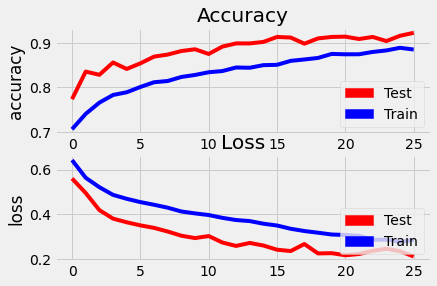

Epoch 27/100
379/379 [==============================] - 163s 430ms/step - loss: 0.2715 - accuracy: 0.8916 - f1_m: 0.8912 - precision_m: 0.8945 - recall_m: 0.8881 - val_loss: 0.2088 - val_accuracy: 0.9201 - val_f1_m: 0.9190 - val_precision_m: 0.9199 - val_recall_m: 0.9181

Epoch 00027: val_loss improved from 0.21237 to 0.20883, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


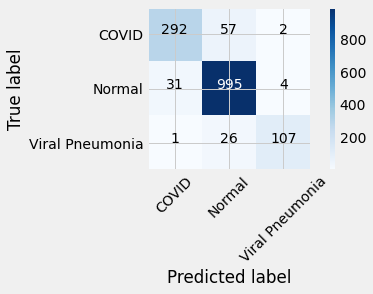

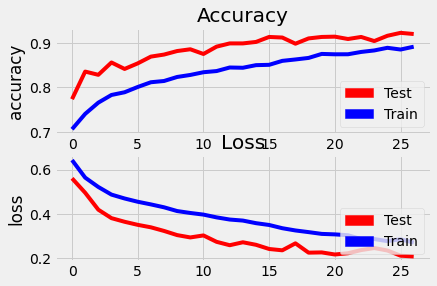

Epoch 28/100
379/379 [==============================] - 162s 428ms/step - loss: 0.2673 - accuracy: 0.8924 - f1_m: 0.8926 - precision_m: 0.8957 - recall_m: 0.8896 - val_loss: 0.1914 - val_accuracy: 0.9248 - val_f1_m: 0.9238 - val_precision_m: 0.9256 - val_recall_m: 0.9220

Epoch 00028: val_loss improved from 0.20883 to 0.19140, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


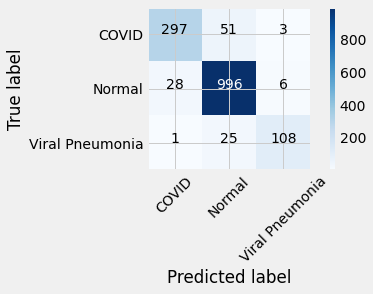

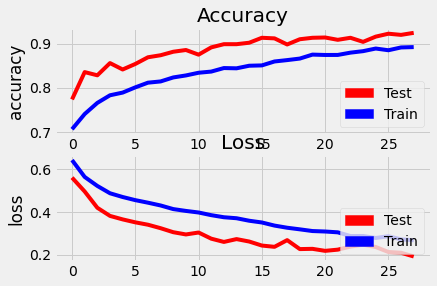

Epoch 29/100
379/379 [==============================] - 163s 429ms/step - loss: 0.2607 - accuracy: 0.8959 - f1_m: 0.8952 - precision_m: 0.8981 - recall_m: 0.8924 - val_loss: 0.2032 - val_accuracy: 0.9261 - val_f1_m: 0.9245 - val_precision_m: 0.9251 - val_recall_m: 0.9239

Epoch 00029: val_loss did not improve from 0.19140


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


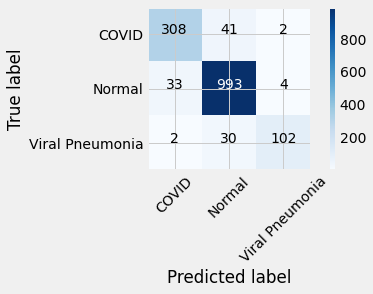

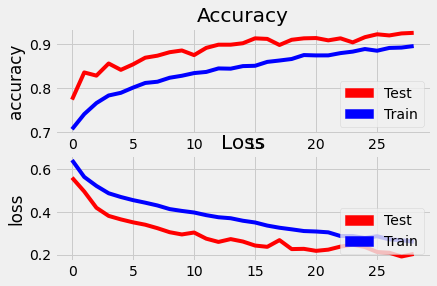

Epoch 30/100
379/379 [==============================] - 161s 425ms/step - loss: 0.2578 - accuracy: 0.8956 - f1_m: 0.8953 - precision_m: 0.8978 - recall_m: 0.8929 - val_loss: 0.1956 - val_accuracy: 0.9307 - val_f1_m: 0.9287 - val_precision_m: 0.9297 - val_recall_m: 0.9279

Epoch 00030: val_loss did not improve from 0.19140


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


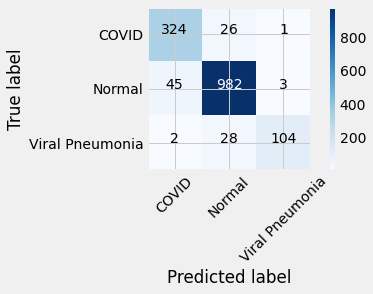

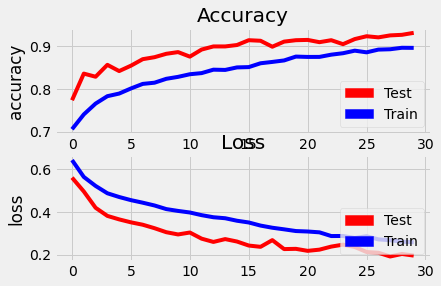

Epoch 31/100
379/379 [==============================] - 160s 423ms/step - loss: 0.2521 - accuracy: 0.8983 - f1_m: 0.8980 - precision_m: 0.9009 - recall_m: 0.8951 - val_loss: 0.1878 - val_accuracy: 0.9267 - val_f1_m: 0.9264 - val_precision_m: 0.9276 - val_recall_m: 0.9252

Epoch 00031: val_loss improved from 0.19140 to 0.18785, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


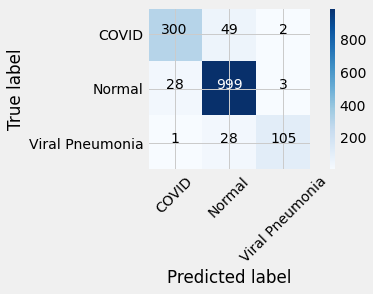

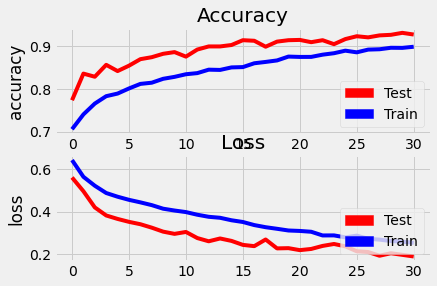

Epoch 32/100
379/379 [==============================] - 160s 423ms/step - loss: 0.2481 - accuracy: 0.8989 - f1_m: 0.8986 - precision_m: 0.9009 - recall_m: 0.8963 - val_loss: 0.1876 - val_accuracy: 0.9261 - val_f1_m: 0.9248 - val_precision_m: 0.9257 - val_recall_m: 0.9239

Epoch 00032: val_loss improved from 0.18785 to 0.18765, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


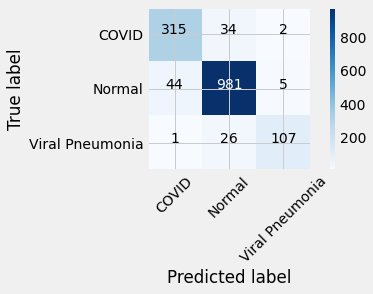

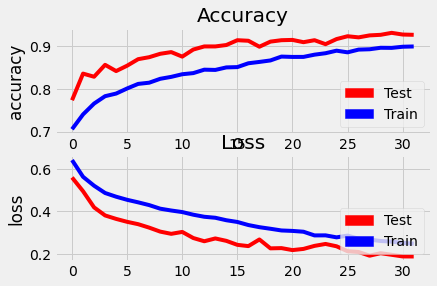

Epoch 33/100
379/379 [==============================] - 160s 423ms/step - loss: 0.2452 - accuracy: 0.9029 - f1_m: 0.9025 - precision_m: 0.9046 - recall_m: 0.9005 - val_loss: 0.1722 - val_accuracy: 0.9373 - val_f1_m: 0.9360 - val_precision_m: 0.9363 - val_recall_m: 0.9357

Epoch 00033: val_loss improved from 0.18765 to 0.17218, saving model to best_model1.h5


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


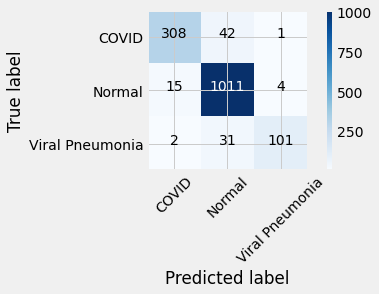

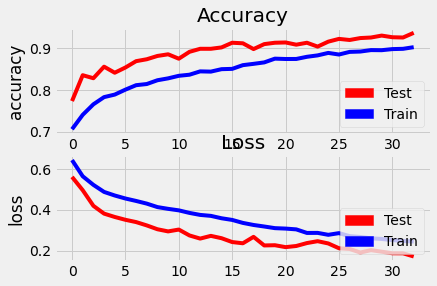

Epoch 34/100
379/379 [==============================] - 161s 424ms/step - loss: 0.2426 - accuracy: 0.9059 - f1_m: 0.9057 - precision_m: 0.9083 - recall_m: 0.9032 - val_loss: 0.2052 - val_accuracy: 0.9281 - val_f1_m: 0.9264 - val_precision_m: 0.9277 - val_recall_m: 0.9252

Epoch 00034: val_loss did not improve from 0.17218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


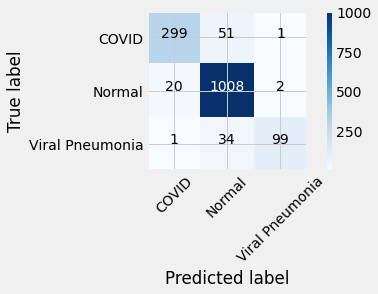

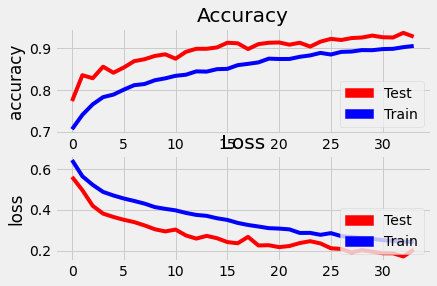

Epoch 35/100
379/379 [==============================] - 161s 424ms/step - loss: 0.2323 - accuracy: 0.9093 - f1_m: 0.9095 - precision_m: 0.9118 - recall_m: 0.9074 - val_loss: 0.1945 - val_accuracy: 0.9314 - val_f1_m: 0.9291 - val_precision_m: 0.9297 - val_recall_m: 0.9285

Epoch 00035: val_loss did not improve from 0.17218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


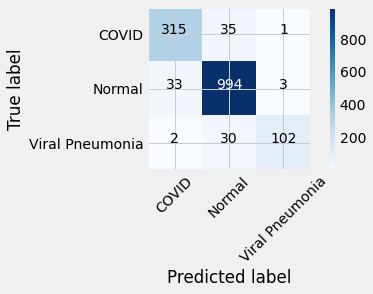

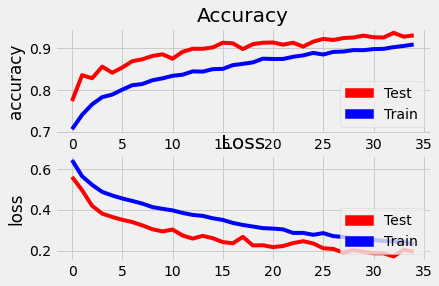

Epoch 36/100
379/379 [==============================] - 161s 425ms/step - loss: 0.2388 - accuracy: 0.9074 - f1_m: 0.9074 - precision_m: 0.9097 - recall_m: 0.9052 - val_loss: 0.2012 - val_accuracy: 0.9320 - val_f1_m: 0.9301 - val_precision_m: 0.9304 - val_recall_m: 0.9298

Epoch 00036: val_loss did not improve from 0.17218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


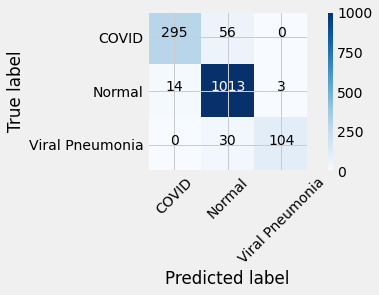

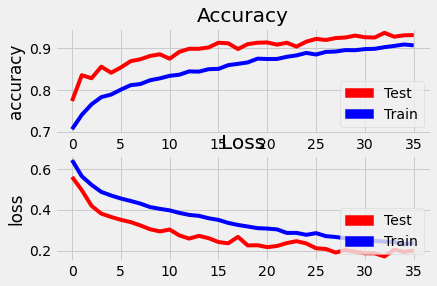

Epoch 37/100
379/379 [==============================] - 161s 425ms/step - loss: 0.2268 - accuracy: 0.9099 - f1_m: 0.9104 - precision_m: 0.9128 - recall_m: 0.9082 - val_loss: 0.1808 - val_accuracy: 0.9406 - val_f1_m: 0.9382 - val_precision_m: 0.9389 - val_recall_m: 0.9376

Epoch 00037: val_loss did not improve from 0.17218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


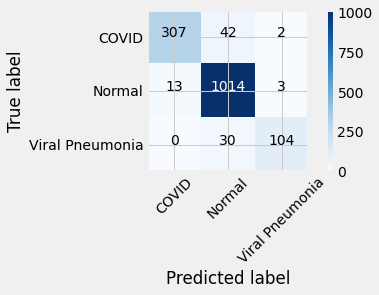

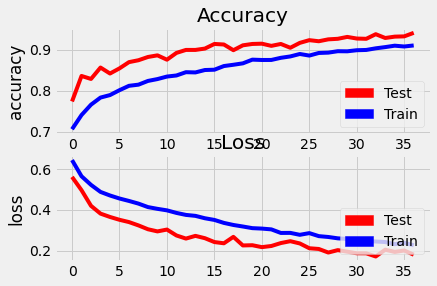

Epoch 38/100
379/379 [==============================] - 160s 423ms/step - loss: 0.2210 - accuracy: 0.9173 - f1_m: 0.9171 - precision_m: 0.9194 - recall_m: 0.9149 - val_loss: 0.1949 - val_accuracy: 0.9393 - val_f1_m: 0.9376 - val_precision_m: 0.9382 - val_recall_m: 0.9370

Epoch 00038: val_loss did not improve from 0.17218


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


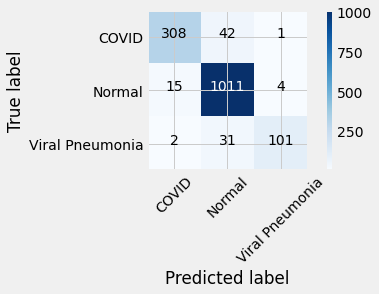

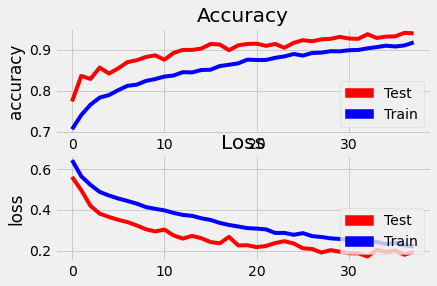

Trained


In [24]:
trained = train(model, train_generator, val_generator, toy)

# MODEL EVALUATION

## Generate Predictions

In [25]:
y_pred_raw = model.predict(test_generator)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = test.category.values
y_true=y_true[:len(y_pred)]

## Metrics Plot Functions

In [26]:
def plot_history(training):
        """
        Plot training history
        """
        ## Trained model analysis and evaluation
        f, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].plot(training.history['loss'], label="Loss")
        ax[0].plot(training.history['val_loss'], label="Validation loss")
        ax[0].set_title('Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Accuracy
        ax[1].plot(training.history['accuracy'], label="Accuracy")
        ax[1].plot(training.history['val_accuracy'], label="Validation accuracy")
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.tight_layout()
        plt.show()

def train_report(training):
    print("------- Training Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['loss'])))

    print("------- Validation Report -----------")
    print("Accuracy: %0.2f" % (np.mean(training.history['val_accuracy'])*100))
    print("F1 Score: %0.2f" % (np.mean(training.history['val_f1_m'])*100))
    print("Precision: %0.2f" % (np.mean(training.history['val_precision_m'])*100))
    print("Recall: %0.2f" % (np.mean(training.history['val_recall_m'])*100))
    print("Loss: %0.2f" % (np.mean(training.history['val_loss'])))

def print_report():
    """
    Predict and evaluate using ground truth from labels
    Test generator did not shuffle 
    and we can use true labels for comparison
    """
    #Print classification report
    print(metrics.classification_report(y_true, y_pred.astype(str), target_names = labels))
    
def print_conf_mtx():
    
    cm = confusion_matrix(y_true.astype(int), y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## Results

------- Training Report -----------
Accuracy: 85.53
F1 Score: 85.41
Precision: 86.07
Recall: 84.78
Loss: 0.34
------- Validation Report -----------
Accuracy: 89.89
F1 Score: 89.69
Precision: 90.22
Recall: 89.21
Loss: 0.27


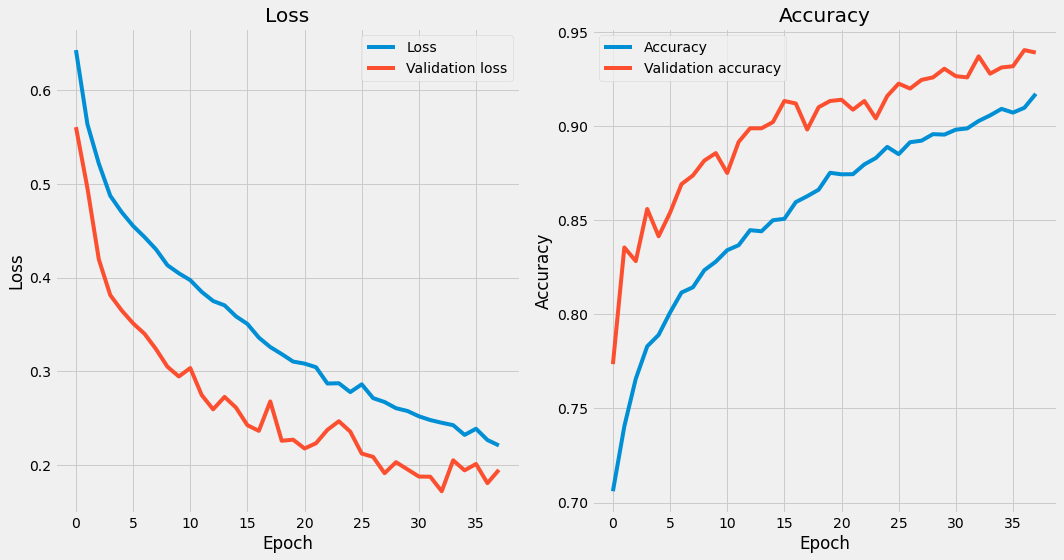

                 precision    recall  f1-score   support

          COVID       0.94      0.87      0.90       380
         Normal       0.94      0.98      0.96      1012
Viral Pneumonia       0.94      0.85      0.89       124

       accuracy                           0.94      1516
      macro avg       0.94      0.90      0.92      1516
   weighted avg       0.94      0.94      0.94      1516



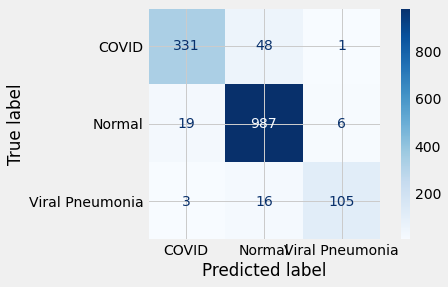

In [27]:
train_report(trained)
plot_history(trained)
print_report()
print_conf_mtx()